In [115]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
# from support_functions import *
from sklearn.cluster import KMeans

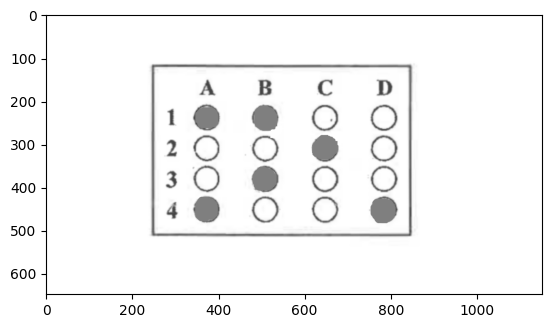

In [116]:
path = r"D:\examark\Untitled.png"
img = cv2.imread(path)
plt.imshow(img)
plt.show()

In [117]:
model = YOLO('../model/best.pt')

results = model([path])  # return a list of Results objects

# Process results list
root = None
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    root = result
    root.show()


0: 384x640 6 0s, 11 1s, 32.4ms
Speed: 0.0ms preprocess, 32.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


In [168]:
def inference(image, part):
    results = model(image)

    list_boxes = []
    for result in results:
        out_img = result.orig_img
        boxes = result.boxes.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy()
        scores = result.boxes.conf.cpu().numpy()
        for i in range(len(boxes)):
            class_id = class_ids[i]
            box = boxes[i]
            x_min, y_min, x_max, y_max = box.xyxy[0]
            center_x = (x_min + x_max) / 2
            center_y = (y_min + y_max) / 2
            h = abs(x_max-x_min)
            w = abs(y_max-y_min)
            class_id = int(class_ids[i])
            if part == 0:
                # if 23 < x_max - x_min < 43 and 26 < y_max - y_min < 46: 
                    list_boxes.append((center_x, center_y, int(class_id), out_img[int(y_min):int(y_max), int(x_min):int(x_max)])) 
            elif part == 1 or part == 2:
                # if 32 < x_max - x_min < 52 and 32 < y_max - y_min < 52: 
                    list_boxes.append((center_x, center_y, int(class_id), out_img[int(y_min):int(y_max), int(x_min):int(x_max)])) 

            # else:
            #     if 26 < x_max - x_min < 46 and 26 < y_max - y_min < 46: 
            #         list_boxes.append((center_x, center_y, int(class_id))) 

    return list_boxes

#num_center_x là số hàng
#num_center_y là số cột
#trong hàm inference, lấy height, with của box
#trong hàm kmeans, cắt được box để xử lý rule base
def kmeans_processing(list_boxes, num_center_x, num_center_y):
    list_x = np.array(list_boxes, dtype=object)[:, 0]
    # print(list_x)
    list_y = np.array(list_boxes, dtype=object)[:, 1]

    kmeans_x = KMeans(n_clusters=num_center_x, random_state=0).fit(list_x.reshape(-1, 1))
    kmeans_y = KMeans(n_clusters=num_center_y, random_state=0).fit(list_y.reshape(-1, 1))

    array_boxes = np.zeros((num_center_y, num_center_x))

    sorted_centers_x = np.sort(kmeans_x.cluster_centers_.flatten())
    
    sorted_centers_y = np.sort(kmeans_y.cluster_centers_.flatten())
    
    circle_dict = {
         "image":[],
         "index":[]
    }
    for box in list_boxes:
        new_point = box[:2]
        new_point_class_id = box[2]
        sub_img = box[3]
        center_idx_x = np.argmin(np.abs(sorted_centers_x - new_point[0]))
        center_idx_y = np.argmin(np.abs(sorted_centers_y - new_point[1]))

        if new_point_class_id == 0:
            array_boxes[center_idx_y, center_idx_x] = 1
        else:
            array_boxes[center_idx_y, center_idx_x] = 0

        circle_dict["image"].append(sub_img)
        circle_dict["index"].append((center_idx_y, center_idx_x))
    
    row_idx_err = []

    print("Ma trận ban đầu : ",array_boxes)
    for row in range(array_boxes.shape[0]):
         count = 0
         for col in range(array_boxes.shape[1]):
            if array_boxes[row][col] == 1:
                 count+=1
         if count > 1:
            row_idx_err.append(row)

    min_avg_list = []
    for err_row in row_idx_err:
        min_avg_pixel = 9999999
    
        array_boxes[err_row][:] = 0
        for col in range(array_boxes.shape[1]):
            
            idx_circle_img = circle_dict["index"].index((err_row, col))
            circle_img_correspond = circle_dict["image"][idx_circle_img]
            h = circle_img_correspond.shape[0]
            w = circle_img_correspond.shape[1]
            avg_pixel = np.sum(circle_img_correspond)/(h*w)
            if avg_pixel < min_avg_pixel:
                min_avg_pixel = avg_pixel
                key_row = err_row
                key_col = col
        array_boxes[key_row][key_col] = 1    


    return array_boxes

In [169]:
lst_box = inference(img, 0)
arr_box = kmeans_processing(lst_box, 4, 4)
print("Ma trận lúc sau : ",arr_box)


0: 384x640 6 0s, 11 1s, 257.1ms
Speed: 4.1ms preprocess, 257.1ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)
Ma trận ban đầu :  [[          1           1           0           0]
 [          0           0           1           0]
 [          0           0           0           0]
 [          1           0           0           1]]
Ma trận lúc sau :  [[          0           1           0           0]
 [          0           0           1           0]
 [          0           0           0           0]
 [          1           0           0           0]]
